In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error

In [2]:
df = pd.read_csv("../DBtrainrides_complete_preprocessed_2.csv")

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../utils')))  # Add the parent directory to the path

from utils import fill_missing_times, normalize_dates, ordinal_scaling, custom_train_test_split

In [4]:
# df.to_csv("DBtrainrides_normalised.csv", index=False)

In [5]:
# df = pd.read_csv("DBtrainrides_normalised.csv")

In [6]:
X_train, y_train, X_test, y_test = custom_train_test_split(df, "arrival_delay_m", 0.8)

# Linear Regression

In [7]:
linear_regressor = LinearRegression()

In [8]:
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

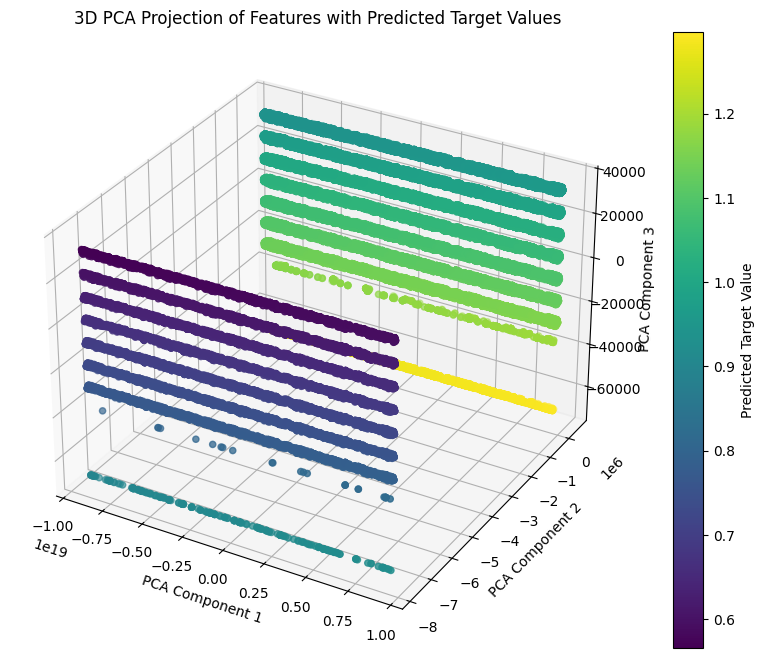

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Apply PCA to reduce the dimensionality to 3 dimensions
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X_test)

# Create a 3D scatter plot of the reduced features, colored by predicted target values
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=y_pred, cmap='viridis')
fig.colorbar(scatter, label='Predicted Target Value')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D PCA Projection of Features with Predicted Target Values')
plt.show()


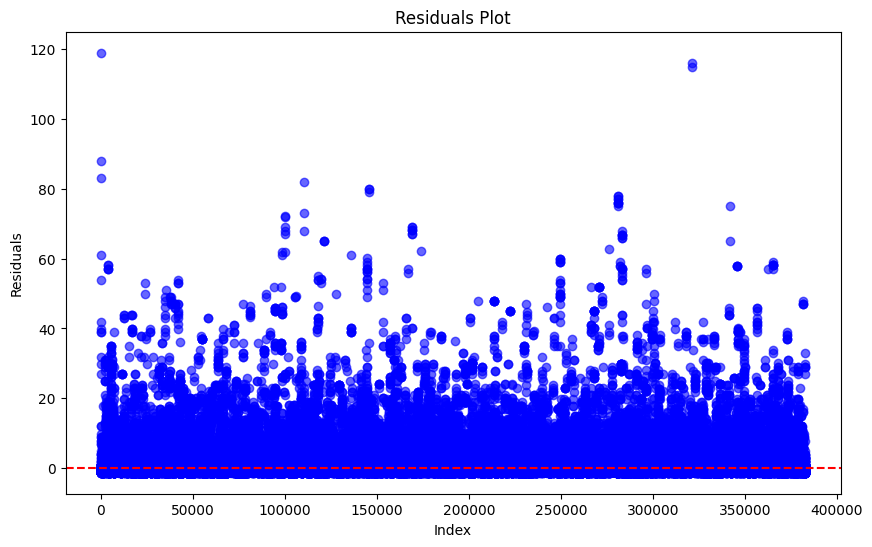

In [10]:
# Assuming you have actual target values (cleaned_target_test)
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, c='b', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [11]:
# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mse)
print("R^2 Score:", r2)

Mean Absolute Error: 1.5094009208867059
R^2 Score: 0.0009534924513624476


Cross-Validation MAE: 1.4945 ± 0.0044


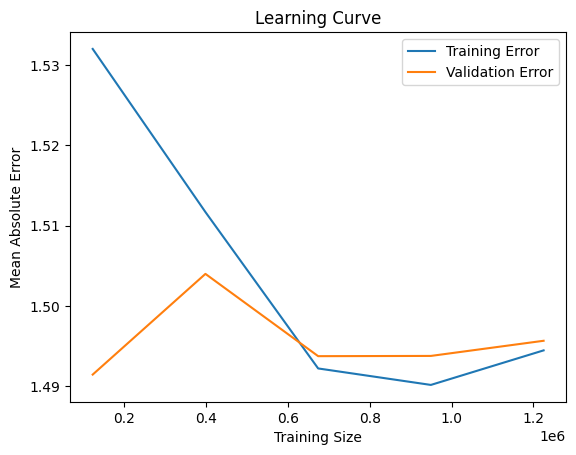

In [12]:
# Cross-validation with MAE
from sklearn.model_selection import KFold, learning_curve


kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(linear_regressor, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)
print(f"Cross-Validation MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    linear_regressor, X_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training Error")
plt.plot(train_sizes, test_scores_mean, label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [13]:
param_space = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

In [14]:
grid_search_lr = GridSearchCV(linear_regressor, param_space, cv=5)
grid_search_lr.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 5, 10, 15, None],
                         'positive': [True, False]})

In [15]:
results = pd.DataFrame(grid_search_lr.cv_results_)
cv_params = results["params"]
cv_mean_test_score = results["mean_test_score"]
param_test_scores = []

In [16]:
for key in cv_params.keys():
    param = str(cv_params[key])
    score = float(cv_mean_test_score[key])
    target = (param, score)
    param_test_scores.append(target)

In [17]:
param_test_scores = sorted(param_test_scores, key=lambda x: x[1], reverse=True)

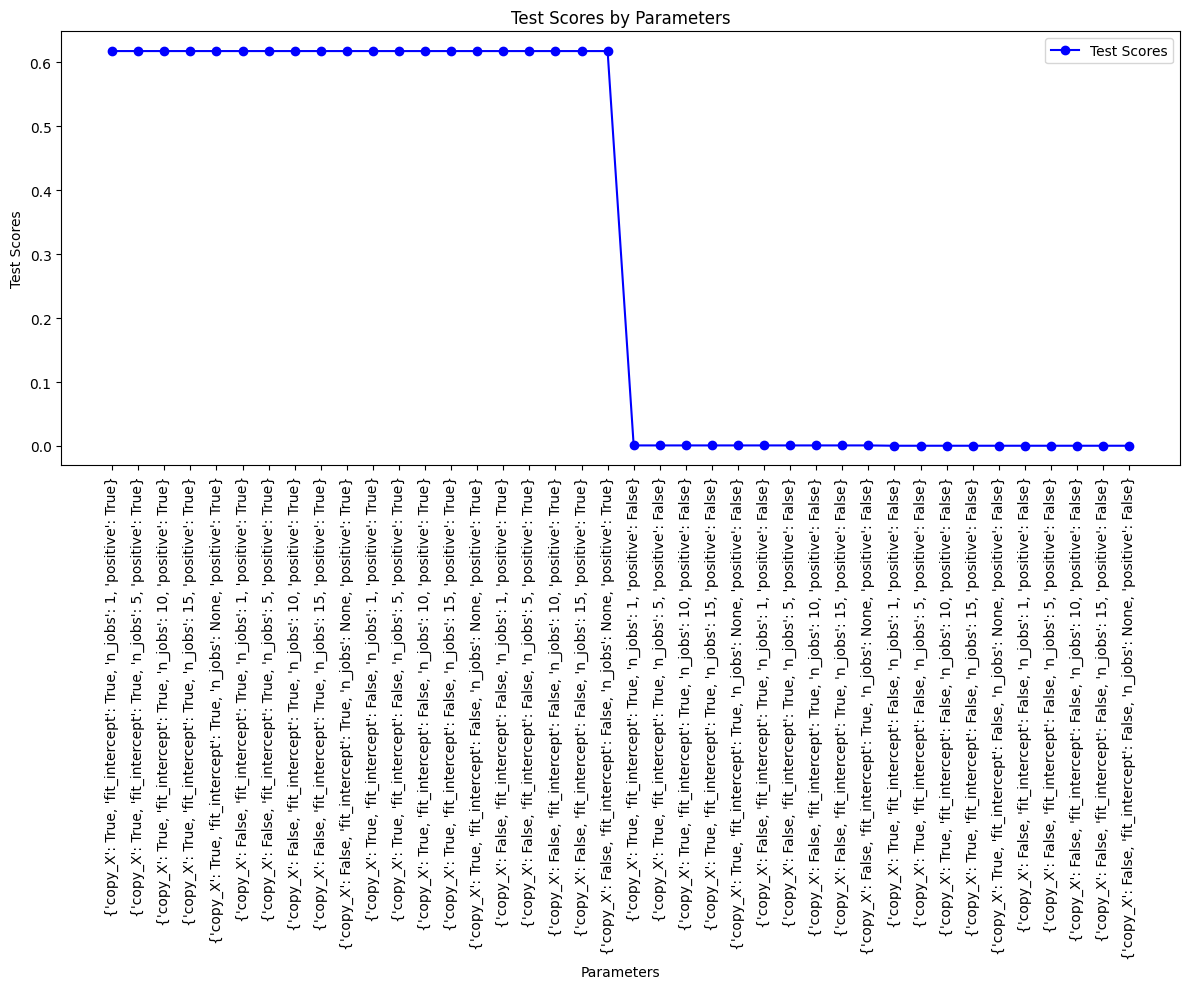

In [18]:
plt.figure(figsize=(12, 10))
plt.plot(
    [param for param, _ in param_test_scores],  # x-axis: parameters
    [score for _, score in param_test_scores],  # y-axis: test_scores
    marker='o', linestyle='-', color='b', label='Test Scores'
)

# Add labels and title
plt.xlabel('Parameters')
plt.ylabel('Test Scores')
plt.title('Test Scores by Parameters')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

In [19]:
linear_regressor = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, positive=True)
linear_regressor.fit(X_train, y_train)

LinearRegression(n_jobs=1, positive=True)

In [20]:
y_pred = linear_regressor.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 0.7380460578791739
R2 Score: 0.5890830588510816


# 4 Spatial MSE

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: Define Germany's geographic boundaries (approximate)
germany_bounds = {
    'min_lat': 47.0, 'max_lat': 55.0,  # Latitude range
    'min_lon': 5.0, 'max_lon': 15.0    # Longitude range
}

# Create a grid over Germany
def create_grid(bounds, cell_size):
    lat_edges = np.arange(bounds['min_lat'], bounds['max_lat'], cell_size)
    lon_edges = np.arange(bounds['min_lon'], bounds['max_lon'], cell_size)
    return lat_edges, lon_edges

# Define cell size (in degrees)
cell_size = 0.25  # Adjust for desired resolution (smaller = finer grid)

lat_edges, lon_edges = create_grid(germany_bounds, cell_size)

# Assign test data points to grid cells
# Assuming X_test has 'latitude' and 'longitude' columns
X_test['lat_bin'] = pd.cut(X_test['lat'], bins=lat_edges)
X_test['lon_bin'] = pd.cut(X_test['long'], bins=lon_edges)

# Combine with y_test and y_pred
data = pd.DataFrame({
    'lat_bin': X_test['lat_bin'],
    'lon_bin': X_test['lon_bin'],
    'y_test': y_test,
    'y_pred': y_pred
})

# Compute squared error
data['squared_error'] = (data['y_test'] - data['y_pred'])**2

# Group by grid cells and compute MSE
spatial_mse = data.groupby(['lat_bin', 'lon_bin'])['squared_error'].mean().reset_index()
spatial_mse.rename(columns={'squared_error': 'spatial_mse'}, inplace=True)

# Add grid cell centers for visualization
spatial_mse['lat_center'] = spatial_mse['lat_bin'].apply(lambda x: x.mid)
spatial_mse['lon_center'] = spatial_mse['lon_bin'].apply(lambda x: x.mid)


/tmp/ipykernel_15125/1850015241.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_mse = data.groupby(['lat_bin', 'lon_bin'])['squared_error'].mean().reset_index()


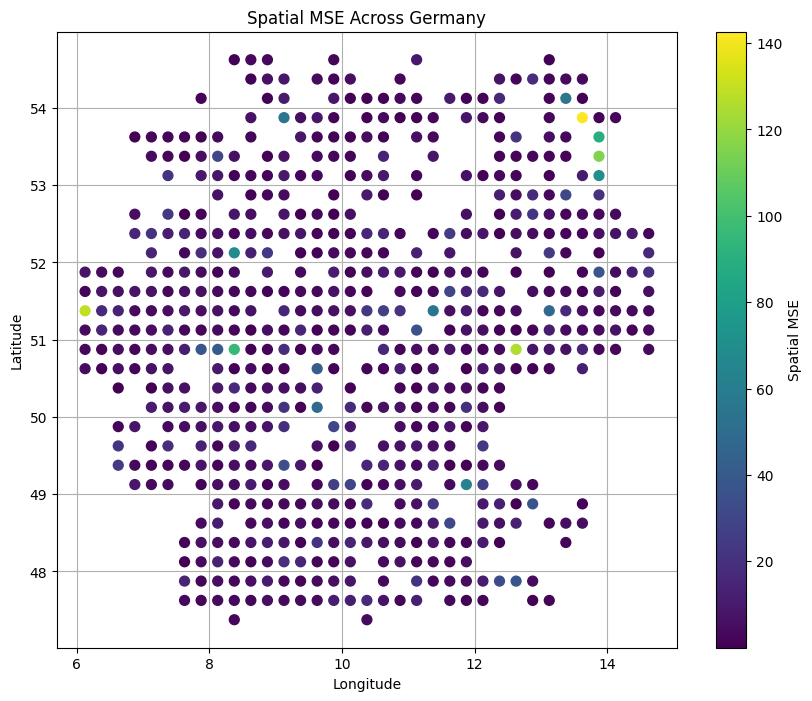

In [22]:
plt.figure(figsize=(10, 8))
plt.scatter(spatial_mse['lon_center'], spatial_mse['lat_center'], c=spatial_mse['spatial_mse'], cmap='viridis', s=50)
plt.colorbar(label='Spatial MSE')
plt.title('Spatial MSE Across Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [23]:
overall_spatial_mse = spatial_mse['spatial_mse'].mean()
overall_spatial_mse

np.float64(8.072386397769582)